In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
import torch
from torch.utils.data import random_split

from torch.utils.data import Dataset

In [2]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Apple GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA GPU")
else:
    device = torch.device('cpu')

Apple GPU


In [3]:
def getData(path):
    train_file = np.load(path+"/train.npz")
    train_data = train_file['data']
    test_file = np.load(path+"/test_input.npz")
    test_data = test_file['data']
    print(f"Training Data's shape is {train_data.shape} and Test Data's is {test_data.shape}")
    return train_data, test_data
trainData, testData = getData("./data/")

Training Data's shape is (10000, 50, 110, 6) and Test Data's is (2100, 50, 50, 6)


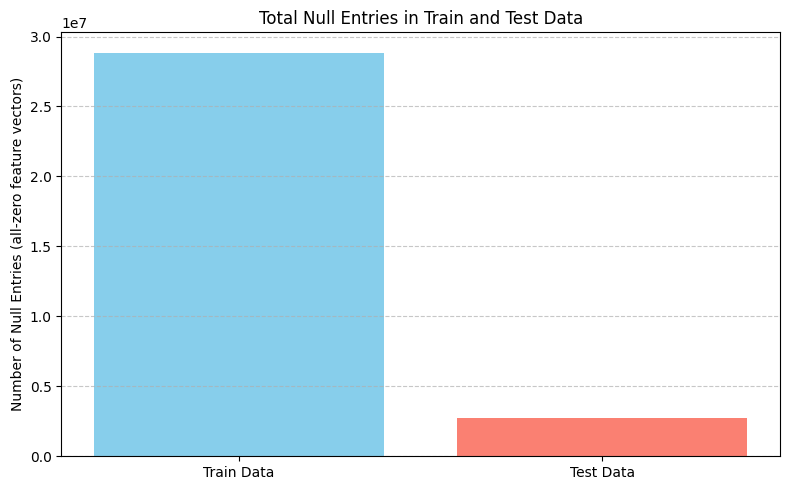

In [ ]:

train_nulls = np.all(trainData == 0, axis=-1).sum()
test_nulls = np.all(testData == 0, axis=-1).sum()

plt.figure(figsize=(8, 5))
plt.bar(['Train Data', 'Test Data'], [train_nulls, test_nulls], color=['skyblue', 'salmon'])
plt.ylabel('Number of Null Entries (all-zero feature vectors)')
plt.title('Total Null Entries in Train and Test Data')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


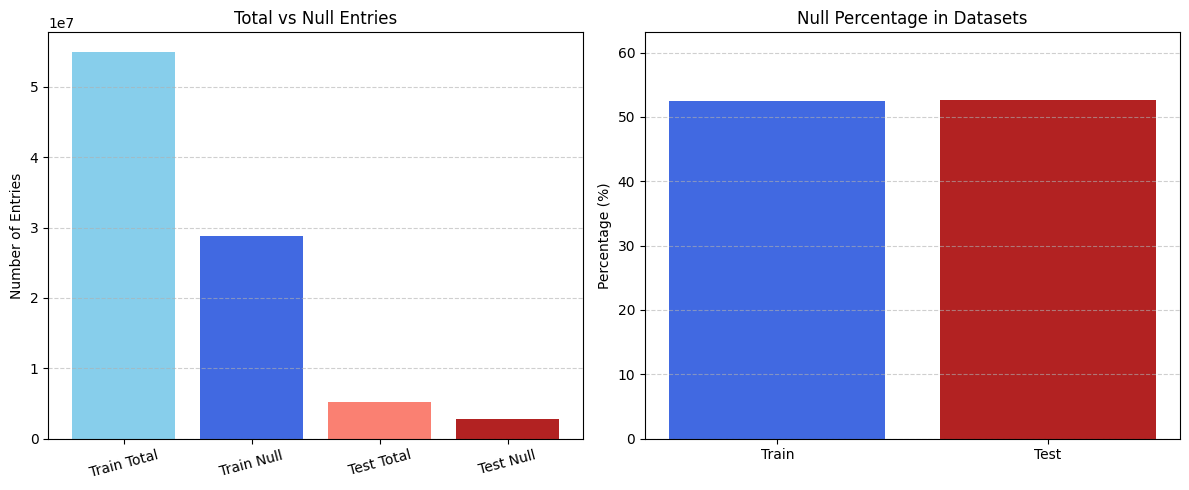

In [ ]:

total_train_entries = np.prod(trainData.shape[:-1])  # 10000 * 50 * 110
total_test_entries = np.prod(testData.shape[:-1])    # 2100 * 50 * 50
train_nulls = np.all(trainData == 0, axis=-1).sum()
test_nulls = np.all(testData == 0, axis=-1).sum()

train_null_pct = (train_nulls / total_train_entries) * 100
test_null_pct = (test_nulls / total_test_entries) * 100

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(['Train Total', 'Train Null', 'Test Total', 'Test Null'],
        [total_train_entries, train_nulls, total_test_entries, test_nulls],
        color=['skyblue', 'royalblue', 'salmon', 'firebrick'])
plt.title('Total vs Null Entries')
plt.ylabel('Number of Entries')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.bar(['Train', 'Test'], [train_null_pct, test_null_pct], color=['royalblue', 'firebrick'])
plt.title('Null Percentage in Datasets')
plt.ylabel('Percentage (%)')
plt.ylim(0, max(train_null_pct, test_null_pct) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [7]:
class WindowedNormalizedDataset(Dataset):
    def __init__(self, data, scale=10.0):
        self.data = data
        self.scale = scale
        self.dt = 0.1 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx].copy()
        presence = (scene[..., 0] != 0) | (scene[..., 1] != 0)

        origin = scene[0, 49].copy()
        tx, ty, _, _, theta, _ = origin

        cos_theta = np.cos(-theta)
        sin_theta = np.sin(-theta)

        normalized_scene = np.zeros((50, 110, 11), dtype=np.float32)

        # --- Normalize positions ---
        x = scene[..., 0] - tx
        y = scene[..., 1] - ty
        x_n = x * cos_theta - y * sin_theta
        y_n = x * sin_theta + y * cos_theta
        normalized_scene[..., 0] = x_n / self.scale
        normalized_scene[..., 1] = y_n / self.scale

        # --- Normalize velocities ---
        vx = scene[..., 2]
        vy = scene[..., 3]
        vx_n = vx * cos_theta - vy * sin_theta
        vy_n = vx * sin_theta + vy * cos_theta
        normalized_scene[..., 2] = vx_n / self.scale
        normalized_scene[..., 3] = vy_n / self.scale

        # --- Heading normalization ---
        heading = scene[..., 4]
        normalized_heading = heading - theta
        normalized_heading = (normalized_heading + np.pi) % (2 * np.pi) - np.pi
        normalized_scene[..., 4] = normalized_heading

        # --- agent_type (already encoded) /---
        normalized_scene[..., 5] = scene[..., 5] 

        # --- Presence ---
        normalized_scene[..., 6] = presence.astype(np.float32)

   

        # === New Feature 2: Speed ===
        speed = np.sqrt(vx ** 2 + vy ** 2)
        normalized_scene[..., 7] = speed / self.scale  

        # === New Feature 3: Distance to ego ===
        ego_pos = scene[0, :, :2]
        dist_to_ego = np.linalg.norm(scene[..., :2] - ego_pos[None, :, :], axis=-1)
        normalized_scene[..., 8] = dist_to_ego / self.scale

        # === New Feature 1: Minimum Distance to Any Agent (Dynamic Interaction) ===
        positions = scene[..., :2] 

        # === New Feature 2: Acceleration Magnitude (Motion Dynamics) ===
        vx = scene[..., 2]
        vy = scene[..., 3]
        speed = np.sqrt(vx**2 + vy**2)
        
        # Compute acceleration (delta-v / delta-t)
        accel = np.zeros_like(speed)
        accel[:, 1:] = (speed[:, 1:] - speed[:, :-1]) / self.dt
        accel[:, 0] = accel[:, 1]  
        
        normalized_scene[..., 9] = accel / (self.scale / self.dt)  

        # === New Feature 3: Time-to-Collision (TTC) with Ego (Critical Event Metric) ===
        rel_speed = np.sqrt(
            (vx - vx[0:1])**2 + 
            (vy - vy[0:1])**2
        )
        dist_to_ego = np.linalg.norm(
            positions - positions[0:1], 
            axis=-1
        )
        
        ttc = dist_to_ego / (rel_speed + 1e-5)  
        ttc = np.clip(ttc, 0, 10)  
        normalized_scene[..., 10] = ttc / 10.0  

        # --- Masking ---
        missing_mask = np.expand_dims(~presence, -1)
        normalized_scene[..., :11] = np.where(missing_mask, 0, normalized_scene[..., :11])

        # Inputs: first 50 timesteps
        X = normalized_scene[:, :50, :]  

        # Target: ego future positions and presence
        ego_future = normalized_scene[0, 50:]
        Y = np.zeros((60, 3), dtype=np.float32)
        Y[:, :2] = ego_future[:, :2]
        Y[:, 2] = ego_future[:, 6]  

        return (
            torch.tensor(X, dtype=torch.float32),
            torch.tensor(Y, dtype=torch.float32),
            torch.tensor(origin, dtype=torch.float32)
        )

In [8]:
class WindowedNormalizedTestDataset(Dataset):
    def __init__(self, data, scale=10.0):
        self.data = data
        self.scale = scale
        self.dt = 0.1  

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx].copy()
        presence = (scene[..., 0] != 0) | (scene[..., 1] != 0)

        origin = scene[0, 49].copy()
        tx, ty, _, _, theta, _ = origin

        cos_theta = np.cos(-theta)
        sin_theta = np.sin(-theta)

        normalized_scene = np.zeros((50, 50, 11), dtype=np.float32)

        # --- Normalize positions ---
        x = scene[..., 0] - tx
        y = scene[..., 1] - ty
        x_n = x * cos_theta - y * sin_theta
        y_n = x * sin_theta + y * cos_theta
        normalized_scene[..., 0] = x_n / self.scale
        normalized_scene[..., 1] = y_n / self.scale

        # --- Normalize velocities ---
        vx = scene[..., 2]
        vy = scene[..., 3]
        vx_n = vx * cos_theta - vy * sin_theta
        vy_n = vx * sin_theta + vy * cos_theta
        normalized_scene[..., 2] = vx_n / self.scale
        normalized_scene[..., 3] = vy_n / self.scale

        # --- Heading normalization ---
        heading = scene[..., 4]
        normalized_heading = heading - theta
        normalized_heading = (normalized_heading + np.pi) % (2 * np.pi) - np.pi
        normalized_scene[..., 4] = normalized_heading

        # --- agent_type (already encoded) ---
        normalized_scene[..., 5] = scene[..., 5]  

        # --- Presence ---
        normalized_scene[..., 6] = presence.astype(np.float32)

   

        # === New Feature 2: Speed ===
        speed = np.sqrt(vx ** 2 + vy ** 2)
        normalized_scene[..., 7] = speed / self.scale  

        # === New Feature 3: Distance to ego ===
        ego_pos = scene[0, :, :2]  
        dist_to_ego = np.linalg.norm(scene[..., :2] - ego_pos[None, :, :], axis=-1)
        normalized_scene[..., 8] = dist_to_ego / self.scale

        # === New Feature 1: Minimum Distance to Any Agent (Dynamic Interaction) ===
        positions = scene[..., :2]  

        # === New Feature 2: Acceleration Magnitude (Motion Dynamics) ===
        vx = scene[..., 2]
        vy = scene[..., 3]
        speed = np.sqrt(vx**2 + vy**2)
        
        # Compute acceleration (delta-v / delta-t)
        accel = np.zeros_like(speed)
        accel[:, 1:] = (speed[:, 1:] - speed[:, :-1]) / self.dt
        accel[:, 0] = accel[:, 1]  
        
        normalized_scene[..., 9] = accel / (self.scale / self.dt)  

        # === New Feature 3: Time-to-Collision (TTC) with Ego (Critical Event Metric) ===
        rel_speed = np.sqrt(
            (vx - vx[0:1])**2 + 
            (vy - vy[0:1])**2
        )
        dist_to_ego = np.linalg.norm(
            positions - positions[0:1], 
            axis=-1
        )
        
        ttc = dist_to_ego / (rel_speed + 1e-5)  
        ttc = np.clip(ttc, 0, 10)  
        normalized_scene[..., 10] = ttc / 10.0  

        # --- Masking ---
        missing_mask = np.expand_dims(~presence, -1)
        normalized_scene[..., :11] = np.where(missing_mask, 0, normalized_scene[..., :11])

        # Inputs: first 50 timesteps
        X = normalized_scene[:, :50, :]  

        return (
            torch.tensor(X, dtype=torch.float32),
            torch.tensor(origin, dtype=torch.float32)
        )

In [9]:
def denormalize_ego_batch(predicted, origin, scale=10.0):
    """
    Convert batch of normalized (and scaled) ego predictions back to global coordinates.

    predicted: (B, ..., 2) tensor of normalized [x, y] positions
    origin: (B, 6) tensor of ego's reference state at t=49
    Returns:
        (B, ..., 2) tensor of global [x, y] positions
    """
    tx = origin[:, 0]  
    ty = origin[:, 1]  
    theta = origin[:, 4]  

    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)

    # Expand for broadcasting
    while len(cos_theta.shape) < len(predicted.shape) - 1:
        cos_theta = cos_theta.unsqueeze(1)
        sin_theta = sin_theta.unsqueeze(1)
        tx = tx.unsqueeze(1)
        ty = ty.unsqueeze(1)

    # Unscale before denormalizing
    x = predicted[..., 0] * scale
    y = predicted[..., 1] * scale

    # Rotate
    x_rot = x * cos_theta - y * sin_theta
    y_rot = x * sin_theta + y * cos_theta

    # Translate
    x_global = x_rot + tx
    y_global = y_rot + ty

    return torch.stack([x_global, y_global], dim=-1)


In [10]:
trainData[1, 0, 49, :], trainData[1, 0, 50, :]

(array([ 3.16906469e+03,  1.68248551e+03,  5.46145515e+00, -5.85380650e+00,
        -8.22467566e-01,  0.00000000e+00]),
 array([ 3.16959927e+03,  1.68191109e+03,  5.35655550e+00, -5.75120145e+00,
        -8.22600550e-01,  0.00000000e+00]))

In [11]:
data = WindowedNormalizedDataset(trainData)
X, Y, origin = data.__getitem__(1)
X[0, 49, :], Y[0, :], origin.shape

(tensor([ 0.0000,  0.0000,  0.8006,  0.0019,  0.0000,  0.0000,  1.0000,  0.8006,
          0.0000, -0.0057,  0.0000]),
 tensor([7.8468e-02, 9.1270e-05, 1.0000e+00]),
 torch.Size([6]))

In [12]:
# x, y = denormalize_ego(Y[0, :2], origin)
# x, y

In [13]:
import torch
import torch.nn as nn

class TrajectoryTransformer(nn.Module):
    def __init__(self, input_dim=550, model_dim=256, num_heads=8, num_layers=6, dropout=0.1, pred_len=60, num_agents=50):
        super().__init__()
        self.model_dim = model_dim
        self.pred_len = pred_len
        self.num_agents = num_agents
        
        self.trajectory_encoder = nn.Sequential(
            nn.Linear(input_dim, model_dim),
            nn.LayerNorm(model_dim),
            nn.ReLU(),
            nn.Linear(model_dim, model_dim),
            nn.LayerNorm(model_dim),
            nn.ReLU(),
            nn.Linear(model_dim, model_dim),
            nn.LayerNorm(model_dim),
            nn.ReLU()
        )
        
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=model_dim, 
                nhead=num_heads, 
                dropout=dropout, 
                batch_first=True
            ),
            num_layers=num_layers
        )
        
        self.output_fcpre = nn.Linear(model_dim, model_dim)  
        self.output_fc = nn.Linear(model_dim, pred_len * 2)  
    
    def forward(self, x):
        B, N, T, Ft = x.shape
        x = x.view(B, N, T * Ft)  
        agent_tokens = self.trajectory_encoder(x)  
        encoded_tokens = self.transformer_encoder(agent_tokens)  
        ego_token = encoded_tokens[:, 0, :]  
        output = F.relu(self.output_fcpre(ego_token))  
        output = self.output_fc(output)  
        output = output.view(B, self.pred_len, 2)  
        
        return output

# Test run
model = TrajectoryTransformer()
x = torch.randn(1, 50, 50, 11)  
out = model(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {out.shape}")  

print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")

Input shape: torch.Size([1, 50, 50, 11])
Output shape: torch.Size([1, 60, 2])

Model parameters: 8,261,240


In [14]:
model = TrajectoryTransformer().to(device=device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 8261240


In [15]:
np.random.seed(42)
num_samples = trainData.shape[0]
indices = np.random.permutation(num_samples)
split_index = int(0.9 * num_samples)
train_idx, val_idx = indices[:split_index], indices[split_index:]

# Split the data
train_data = trainData[train_idx]
val_data = trainData[val_idx]

print("Train shape:", train_data.shape)
print("Validation shape:", val_data.shape)

Train shape: (9000, 50, 110, 6)
Validation shape: (1000, 50, 110, 6)


In [16]:
trainTensor = WindowedNormalizedDataset(train_data)
testTensor = WindowedNormalizedDataset(val_data)
train_dataloader = DataLoader(trainTensor, batch_size=128, shuffle=True)
val_dataloader = DataLoader(testTensor, batch_size=128, shuffle=False)

In [18]:
torch.cuda.empty_cache()
 #  train MSE 0.0019108728 | train val MSE 0.0105765359 | val MAE 1.9288981240 | val MSE 1.0576545876 (Baseline)
# best_model = torch.load("./models/modelI/best_model.pt")
# model.load_state_dict(best_model)

epochs = 1000
lossFn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-6)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25)
best_val_loss = 0.0105765359 #float('inf')
best_train_loss = 0.0019108728 #float('inf')
position_scale = 1.0
velocity_scale = 1.0
all_losses = {
    'training_mse_loss':[],
    'validation_mse_loss':[],
    'true_mse':[],
    'true_mae':[]
}

for each_epoch in range(epochs):
    model.train()
    runningLoss = 0.0
    loop = tqdm(train_dataloader, desc=f"Epoch [{each_epoch+1}/{epochs}]")
    
    for batchX, batchY, origin in loop:
        batchX = batchX.to(device)
        batchY = batchY.to(device)
        origin = origin.to(device)

        
        pred = model(batchX)  
        
        loss = lossFn(pred[..., :2], batchY[..., :2]).to(device)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        runningLoss += loss.item()        
    
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    
    with torch.no_grad():
        for batchX, batchY, origin in loop:
            batchX = batchX.to(device)
            batchY = batchY.to(device)
            origin = origin.to(device)

            
            pred = model(batchX)  
            
            loss = lossFn(pred[..., :2], batchY[..., :2]).to(device)
            unnorm_pred = denormalize_ego_batch(pred, origin)
            unnorm_true = denormalize_ego_batch(batchY, origin)

            val_loss += loss.item()
            val_mae += nn.L1Loss()(unnorm_pred[..., :2], unnorm_true[..., :2]).item()
            val_mse += nn.MSELoss()(unnorm_pred[..., :2], unnorm_true[..., :2]).item()
    # break
    train_loss = runningLoss/len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    val_mse /= len(val_dataloader)
    
    all_losses["training_mse_loss"].append(train_loss)
    all_losses["validation_mse_loss"].append(val_loss)
    all_losses["true_mse"].append(val_mse)
    all_losses["true_mae"].append(val_mae)
    
    loop.write(f" train MSE {train_loss:.10f} | train val MSE {val_loss:.10f} | val MAE {val_mae:.10f} | val MSE {val_mse:.10f}")
    scheduler.step()
    
    if train_loss < best_train_loss and val_loss < best_val_loss :#- 1e-3
        best_val_loss = val_loss
        best_train_loss = train_loss
        no_improvement = 0
        torch.save(model.state_dict(), "./models/modelI/best_model.pt")
        loop.write(f" model Saved")
    torch.cuda.empty_cache()

Epoch [1/1000]: 100%|██████████| 71/71 [00:20<00:00,  3.51it/s]


 train MSE 0.1059457067 | train val MSE 0.3017143798 | val MAE 8.8871063590 | val MSE 30.1714426875


Epoch [2/1000]: 100%|██████████| 71/71 [00:18<00:00,  3.86it/s]


 train MSE 0.0367750633 | train val MSE 0.2788862719 | val MAE 8.4636404291 | val MSE 27.8886299729


Epoch [3/1000]:  51%|█████     | 36/71 [00:09<00:09,  3.66it/s]


KeyboardInterrupt: 

In [ ]:
 # train MSE 0.0019069660 | train val MSE 0.0094254124 | val MAE 1.8160044458 | val MSE 0.9425422968 - 7.46

test_dataset = WindowedNormalizedTestDataset(testData)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


best_model = torch.load("./models/modelI/best_model.pt")
model = model = TrajectoryTransformer().to(device=device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batchX, origin in test_loader:
        batchX = batchX.to(device)
        batchY = batchY.to(device)
        origin = origin.to(device)

        
        pred = model(batchX)  
        
        unnorm_pred = denormalize_ego_batch(pred[..., :2], origin)
        pred_list.append(unnorm_pred.cpu().numpy())
        

pred_list = np.concatenate(pred_list, axis=0)  
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('./models/modelI/testTransFormer.csv', index=True)

In [ ]:
# train MSE 0.0067906785 | train val MSE 0.0365855057 | val MAE 3.3914739154 | val MSE 3.6585507989 -- Test 8.03946
# train MSE 0.0043151287 | train val MSE 0.0219720890 | val MAE 2.6549732704 | val MSE 2.1972093526 -- Test 7.62
# train MSE 0.0037161494 | train val MSE 0.0218982005 | val MAE 2.6644983813 | val MSE 2.1898213290 -- Test 7.69
# train MSE 0.0025154897 | train val MSE 0.0138957179 | val MAE 2.1490821969 | val MSE 1.3895723280 -- Test 7.54
# train MSE 0.0024351706 | train val MSE 0.0127016097 | val MAE 2.0745492652 | val MSE 1.2701618038 -- Test 7.50
# train MSE 0.0022985399 | train val MSE 0.0120968180 | val MAE 2.0344754625 | val MSE 1.2096826853 
# train MSE 0.0021999973 | train val MSE 0.0113797741 | val MAE 1.9797802214 | val MSE 1.1379772136 -- Test 7.51
# train MSE 0.0020566347 | train val MSE 0.0111485770 | val MAE 1.9614749197 | val MSE 1.1148587456 -- 
# train MSE 0.0019431473 | train val MSE 0.0106567538 | val MAE 1.9321254082 | val MSE 1.0656757262 -- Test 7.48
# train MSE 0.0019361081 | train val MSE 0.0106566806 | val MAE 1.9310559519 | val MSE 1.0656687887 -- Test 7.47883

